In [1]:
import os
import os
import tensorflow as tf
import cv2
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import SMOTE
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.utils import to_categorical
from skimage import filters, exposure
from skimage.morphology import remove_small_objects
from scipy.ndimage import binary_closing, binary_fill_holes
from keras.optimizers import Adam
from keras.callbacks import Callback
from sklearn.metrics import f1_score, roc_auc_score, classification_report, confusion_matrix


In [2]:
#Loading Mat Files
def load_mat_files(dataset_path, image_size=(224, 224)):
    all_images = []
    all_labels = []
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(".mat"):
                file_path = os.path.join(root, file)
                with h5py.File(file_path, 'r') as f:
                    image_data = np.array(f['cjdata']['image'])
                    label = int(np.array(f['cjdata']['label'])[0])
                    image = cv2.resize(image_data, image_size)
                    all_images.append(image)
                    all_labels.append(label)
    return np.array(all_images), np.array(all_labels)

# Load JPEG images
def load_jpeg_images(dataset_path, image_size=(224, 224)):
    images = []
    labels = []
    label_mapping = {'Tr-gl': 2, 'Tr-me': 1, 'Tr-no': 0, 'Tr-pi': 3}
    for filename in os.listdir(dataset_path):
        if filename.endswith(".jpg"):
            img_path = os.path.join(dataset_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, image_size)
            images.append(img)
            label_assigned = False
            for prefix, label in label_mapping.items():
                if filename.startswith(prefix):
                    labels.append(label)
                    label_assigned = True
                    break
            if not label_assigned:
                print(f"No label assigned for: {filename}")
                images.pop()
    return np.array(images), np.array(labels)

# Image preprocessing functions
def skull_strip(image, fill_value=0):
    thresh = filters.threshold_otsu(image)
    binary = image > thresh
    binary = remove_small_objects(binary, min_size=64)
    binary = binary_closing(binary, structure=np.ones((3, 3)))
    binary = binary_fill_holes(binary)
    masked_image = np.where(binary, image, fill_value)
    return masked_image

def noise_reduction(image, kernel_size=3):
    if image.dtype == np.float64:
        image = np.uint8(image * 255)
    blurred = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
    return blurred.astype(np.float64) / 255.0

def contrast_enhancement(image):
    p2, p98 = np.percentile(image, (2, 98))
    image_rescale = exposure.rescale_intensity(image, in_range=(p2, p98))
    return image_rescale

def preprocess_images(images_array):
    preprocessed = []
    for image in images_array:
        stripped = skull_strip(image)
        reduced_noise = noise_reduction(stripped)
        enhanced_contrast = contrast_enhancement(reduced_noise)
        preprocessed.append(enhanced_contrast)
    return np.array(preprocessed)

def visualize_images_and_labels(original_images, preprocessed_images, labels, title_original, title_preprocessed):
    num_images = 4
    fig, axs = plt.subplots(num_images, 2, figsize=(10, num_images * 5))
    for i in range(num_images):
        axs[i, 0].imshow(original_images[i], cmap='gray')
        axs[i, 0].set_title(f'{title_original} - Label: {labels[i]}')
        axs[i, 0].axis('off')
        axs[i, 1].imshow(preprocessed_images[i], cmap='gray')
        axs[i, 1].set_title(f'{title_preprocessed} - Label: {labels[i]}')
        axs[i, 1].axis('off')
    plt.tight_layout()
    plt.show()

def plot_label_distribution(labels, title):
    unique, counts = np.unique(labels, return_counts=True)
    plt.figure(figsize=(8, 5))
    plt.bar(unique, counts, color=['red', 'green', 'blue', 'cyan'])
    plt.xlabel('Labels')
    plt.ylabel('Number of Samples')
    plt.title(title)
    plt.xticks(unique, ['No Tumor', 'Meningioma', 'Glioma', 'Pituitary'])
    plt.show()


In [3]:
# Load datasets
mat_dataset_path = 'C:/Users/omarb/OneDrive/Desktop/MEDICINE DATASETS/MRIBRAIN/brain tumor 1'
mat_images, mat_labels = load_mat_files(mat_dataset_path)

dataset_path = 'C:/Users/omarb/OneDrive/Desktop/MEDICINE DATASETS/MRIBRAIN/Training'
jpeg_images, jpeg_labels = load_jpeg_images(dataset_path)

# Check the range of pixel values before normalization
print(f"mat_images max value before normalization: {np.max(mat_images)}")
print(f"jpeg_images max value before normalization: {np.max(jpeg_images)}")

# Normalize images
# Different normalization method for mat_images to bring the values to 0-1 range
mat_images = mat_images.astype(np.float32)
mat_images = (mat_images - np.min(mat_images)) / (np.max(mat_images) - np.min(mat_images))

jpeg_images = jpeg_images.astype(np.float32) / 255.0

# Check the range of pixel values after normalization
print(f"mat_images max value after normalization: {np.max(mat_images)}")
print(f"jpeg_images max value after normalization: {np.max(jpeg_images)}")

# Concatenate images and labels
images = np.concatenate((jpeg_images, mat_images), axis=0)
labels = np.concatenate((jpeg_labels, mat_labels), axis=0)

# Free memory
del jpeg_images, mat_images, jpeg_labels, mat_labels

# Verify normalization
print(f"images max value: {np.max(images)}")  # Should print 1.0 if normalization i

mat_images max value before normalization: 11495
jpeg_images max value before normalization: 255
mat_images max value after normalization: 1.0
jpeg_images max value after normalization: 1.0
images max value: 1.0


Preprocessed images shape: (8731, 224, 224)
preprocessed_images max value: 1.0


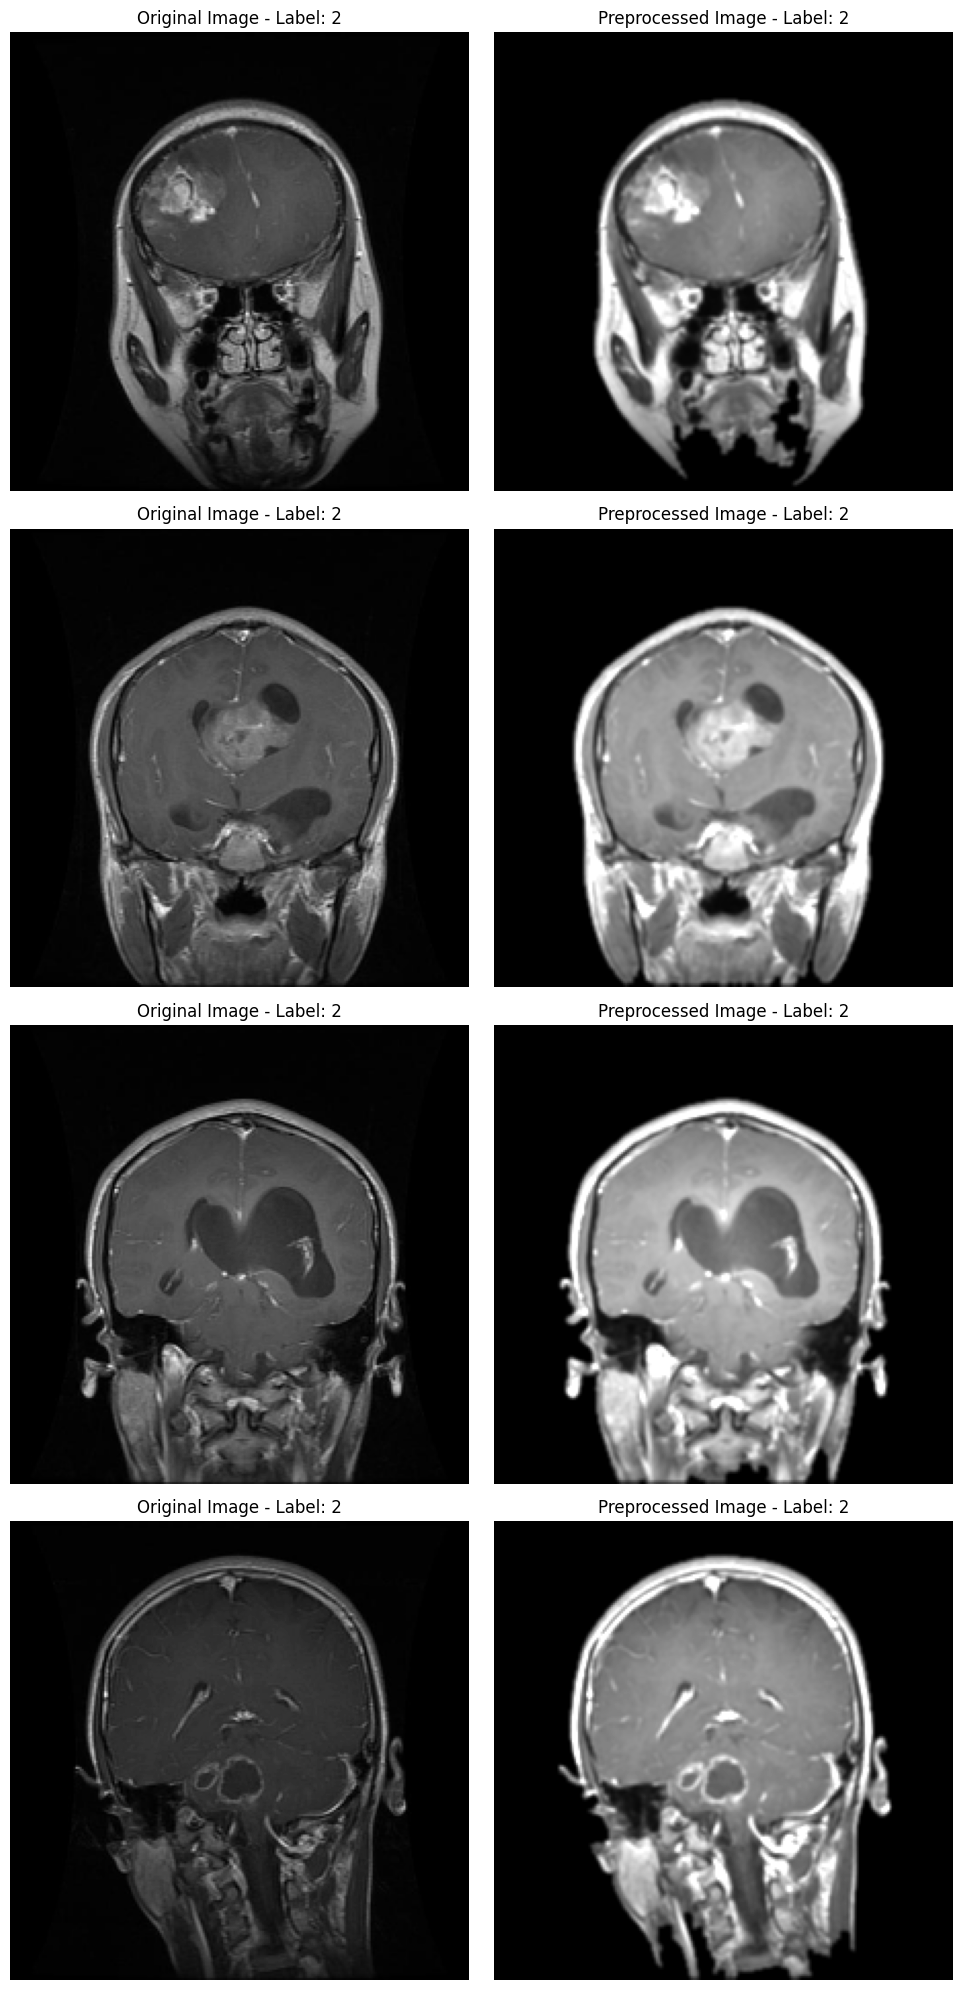

In [4]:

# Define data augmentation configuration
data_gen_args = dict(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
image_data_gen = ImageDataGenerator(**data_gen_args)

preprocessed_images = preprocess_images(images)
print(f"Preprocessed images shape: {preprocessed_images.shape}")
print(f"preprocessed_images max value: {np.max(preprocessed_images)}")  # double check normilzation done correctly 
# Visualize initial images and preprocessed images
visualize_images_and_labels(images, preprocessed_images, labels, "Original Image", "Preprocessed Image")
# Free Memory
del images


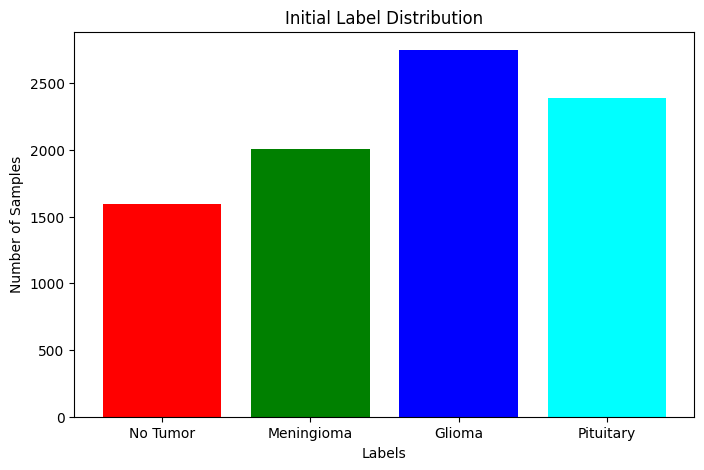

In [5]:
# Visualize initial label distribution
plot_label_distribution(labels, "Initial Label Distribution")

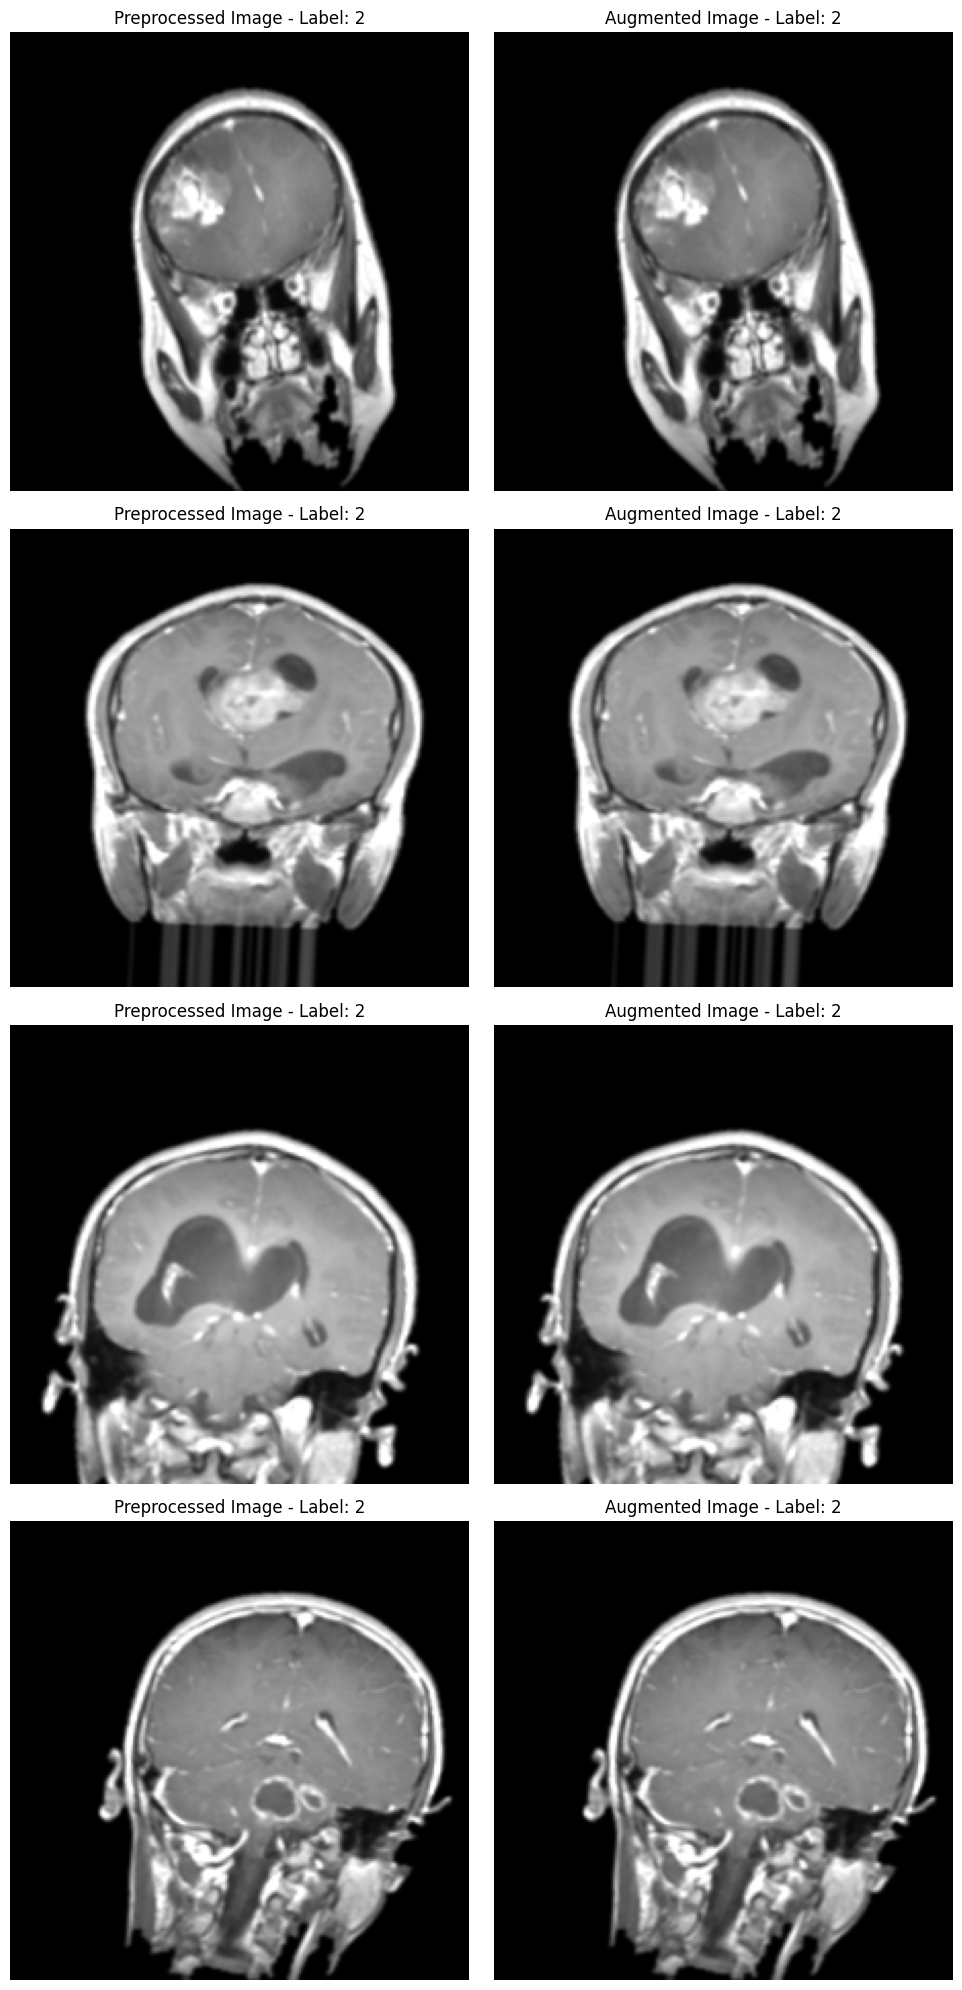

In [6]:
# Apply data augmentation to the preprocessed images
augmented_images = []
augmented_labels = []
augmentation_factor = 1  # Augmentation amount

for image, label in zip(preprocessed_images, labels):
    image = image.reshape(1, 224, 224, 1)
    aug_iter = image_data_gen.flow(image, batch_size=1)
    for _ in range(augmentation_factor):
        aug_image = next(aug_iter)[0].reshape(224, 224)
        augmented_images.append(aug_image)
        augmented_labels.append(label)

# Visualize preprocessed images and augmented images
visualize_images_and_labels(augmented_images[:4], augmented_images[:4], augmented_labels[:4], "Preprocessed Image", "Augmented Image")

Preprocessed images shape: (17462, 224, 224)
all_labels shape: (17462,)
preprocessed_images max value: 1.0


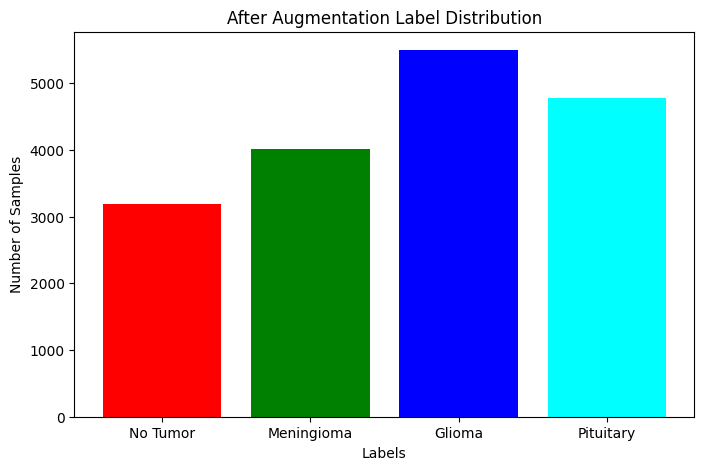

In [7]:
# Combine augmented images and labels with original preprocessed images and labels
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)
all_images = np.concatenate((preprocessed_images, augmented_images), axis=0)
del preprocessed_images

all_labels = np.concatenate((labels, augmented_labels), axis=0)
print(f"Preprocessed images shape: {all_images.shape}")
print(f"all_labels shape: {all_labels.shape}")
print(f"preprocessed_images max value: {np.max(all_images)}")  # Should print 1.0 if normalization done correctly
plot_label_distribution(all_labels, "After Augmentation Label Distribution")

Reshaped images shape for SMOTE: (17462, 50176)
Resampled images shape: (21976, 50176)
Resampled labels distribution: (array([0, 1, 2, 3]), array([5494, 5494, 5494, 5494], dtype=int64))
Reshaped images shape after SMOTE: (21976, 224, 224)


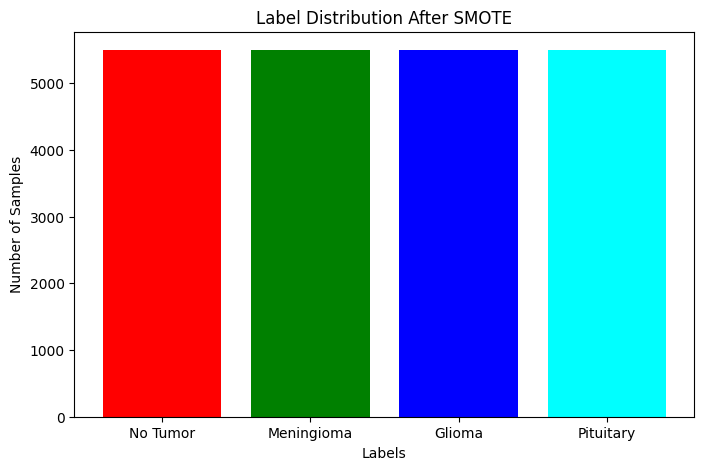

In [8]:
# Reshape images to 2D array for SMOTE
n_samples, height, width = all_images.shape
all_images_reshaped = all_images.reshape((n_samples, height * width))

del all_images
# Print the shape to confirm
print(f"Reshaped images shape for SMOTE: {all_images_reshaped.shape}")

# Apply SMOTE to balance the dataset
smote = SMOTE()
images_resampled, labels_resampled = smote.fit_resample(all_images_reshaped, all_labels)
del all_images_reshaped

# Print the shape of resampled data to confirm
print(f"Resampled images shape: {images_resampled.shape}")
print(f"Resampled labels distribution: {np.unique(labels_resampled, return_counts=True)}")

# Reshape images back to original 3D shape
images_resampled = images_resampled.reshape((-1, height, width))

# Print the shape to confirm
print(f"Reshaped images shape after SMOTE: {images_resampled.shape}")

# Visualize label distribution after SMOTE
plot_label_distribution(labels_resampled, "Label Distribution After SMOTE")


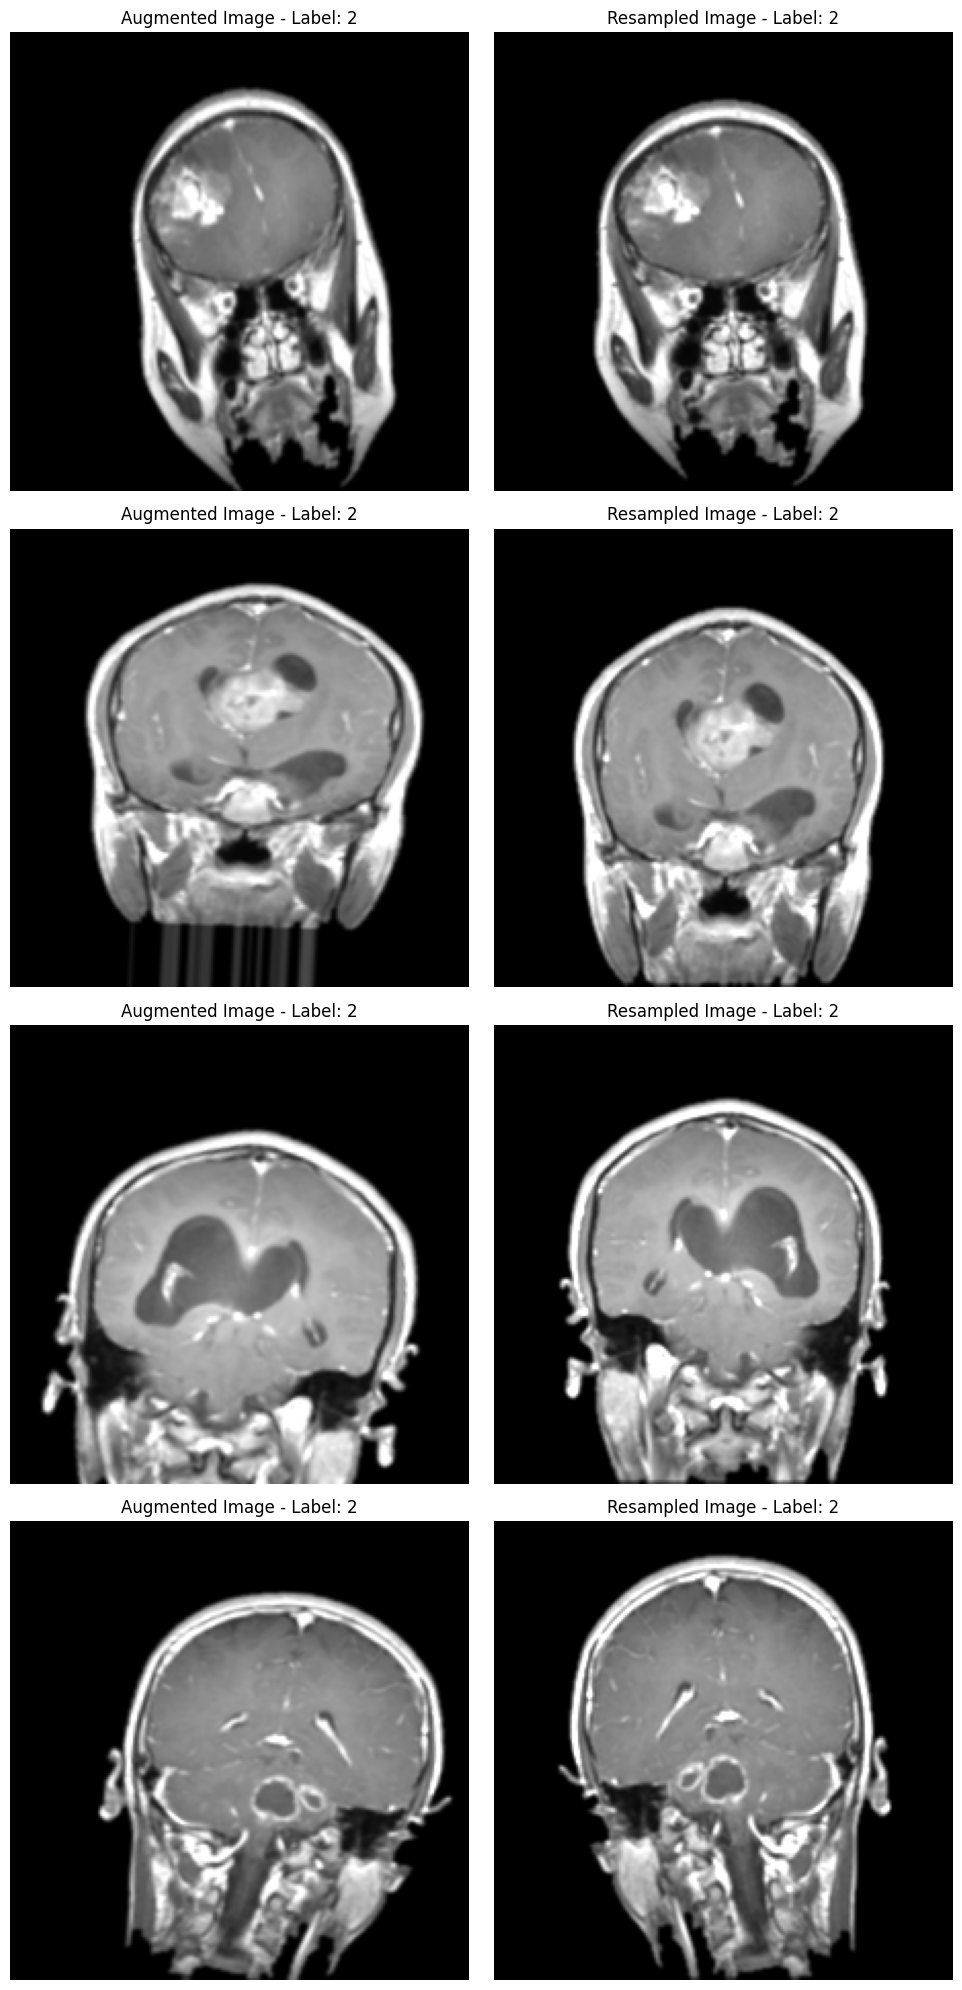

In [9]:
visualize_images_and_labels(augmented_images, images_resampled, labels_resampled, "Augmented Image", "Resampled Image")


In [10]:
# Splitting dataset
X_train, X_temp, y_train, y_temp = train_test_split(images_resampled, labels_resampled, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Reshape and normalize
X_train = X_train.reshape((-1, 224, 224, 1)).astype('float32')
X_val = X_val.reshape((-1, 224, 224, 1)).astype('float32')
X_test = X_test.reshape((-1, 224, 224, 1)).astype('float32')



In [11]:
# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=4)
y_val = to_categorical(y_val, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

In [12]:

print(f"X_train images shape: {X_train.shape}")
#print(f"X_test images shape: {X_test.shape}")
print(f"X_val images shape: {X_val.shape}")
print(f"X_train max value: {X_train.max()}")
#print(f"X_test max value:: {X_test.max()}")
print(f"X_val max value:: {X_val.max()}")
print(f"y_train labels shape: {y_train.shape}")
print(f"y_test labels shape: {y_test.shape}")
print(f"y_val labels shape: {y_val.shape}")

X_train images shape: (15383, 224, 224, 1)
X_val images shape: (3296, 224, 224, 1)
X_train max value: 1.0
X_val max value:: 1.0
y_train labels shape: (15383, 4)
y_test labels shape: (3297, 4)
y_val labels shape: (3296, 4)


In [9]:

# CNN Model
def Brain_Tumor_Classfier():
    model = Sequential([
        Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 1)),
        BatchNormalization(),
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),

        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.4),

        Conv2D(256, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.5),

        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(4, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy',tf.keras.metrics.AUC(name='auc') ])
    return model



In [10]:
model = Brain_Tumor_Classfier()

# Summarize the model
model.summary()

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_auc', patience=10, restore_best_weights=True, mode='max'),
    ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=2, verbose=1, mode='max', min_lr=0.000001),
    tf.keras.callbacks.ModelCheckpoint("BrainTumorClassfier2.h5", monitor="val_auc", save_best_only=True, mode="max")
]


2024-05-15 09:29:03.298067: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-15 09:29:04.130362: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-15 09:29:04.130443: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-15 09:29:04.136641: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-15 09:29:04.136713: I tensorflow/compile

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      640       
                                                                 
 batch_normalization (Batch  (None, 224, 224, 64)      256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 batch_normalization_1 (Bat  (None, 224, 224, 64)      256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                        

In [11]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=8,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)


2024-05-15 09:29:18.296357: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3085221888 exceeds 10% of free system memory.
2024-05-15 09:33:13.912647: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3085221888 exceeds 10% of free system memory.


Epoch 1/50


2024-05-15 09:33:39.159545: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-05-15 09:33:58.719072: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2024-05-15 09:34:00.592527: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-15 09:34:03.850416: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-05-15 09:34:04.234997: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f123c045b70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-15 09:34:04.235037: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor devi

1922/1922 [==============================] - ETA: 0s - loss: 1.4739 - accuracy: 0.5117 - auc: 0.7845

2024-05-15 09:37:39.968571: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 661118976 exceeds 10% of free system memory.
2024-05-15 09:37:40.291305: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 661118976 exceeds 10% of free system memory.
2024-05-15 09:37:50.755152: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
/home/ubo/anaconda3/envs/py310/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1922/1922 [==============================] - 303s 123ms/step - loss: 1.4739 - accuracy: 0.5117 - auc: 0.7845 - val_loss: 0.9055 - val_accuracy: 0.6233 - val_auc: 0.8778 - lr: 1.0000e-04
Epoch 2/50
1922/1922 [==============================] - 265s 138ms/step - loss: 0.9342 - accuracy: 0.5796 - auc: 0.8545 - val_loss: 0.7976 - val_accuracy: 0.6691 - val_auc: 0.9028 - lr: 1.0000e-04
Epoch 3/50
1922/1922 [==============================] - 223s 116ms/step - loss: 0.8485 - accuracy: 0.6213 - auc: 0.8828 - val_loss: 0.6962 - val_accuracy: 0.6976 - val_auc: 0.9187 - lr: 1.0000e-04
Epoch 4/50
1922/1922 [==============================] - 266s 138ms/step - loss: 0.7835 - accuracy: 0.6583 - auc: 0.9008 - val_loss: 0.6903 - val_accuracy: 0.7447 - val_auc: 0.9320 - lr: 1.0000e-04
Epoch 5/50
1922/1922 [==============================] - 231s 120ms/step - loss: 0.6799 - accuracy: 0.7119 - auc: 0.9252 - val_loss: 0.5777 - val_accuracy: 0.7908 - val_auc: 0.9485 - lr: 1.0000e-04
Epoch 6/50
1922/1922 [====